In [1]:
import idx2numpy
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision

In [3]:
train_images = idx2numpy.convert_from_file('data/raw/train-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('data/raw/train-labels-idx1-ubyte')
test_images = idx2numpy.convert_from_file('data/raw/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('data/raw/t10k-labels-idx1-ubyte')

In [4]:
# Check if cuda is avilable in torch
if torch.cuda.is_available():
    print("Detect GPU: {}".format(torch.cuda.get_device_name()))
    device = torch.device('cuda')
else:
    print('No GPU Detected')
    device = torch.device('cpu')

Detect GPU: GeForce GTX 1080


In [5]:
batch_size = 128
epochs = 20
learning_rate = 1e-04
is_transfer_learning = False

# Prepare data

In [6]:
class FashinMnistDataSet(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        images = self.images[idx, :]
        images = images / 255.
        images = np.expand_dims(images, axis=0)
        label = self.labels[idx]
        
        data = {
            'images': torch.tensor(images, dtype=torch.float), 'label': torch.tensor(label, dtype=torch.long)
        }
        return data

In [7]:
train_set = FashinMnistDataSet(train_images, train_labels)
test_set = FashinMnistDataSet(test_images, test_labels)

In [8]:
train_sampler = RandomSampler(train_set)
training_loader = DataLoader(train_set, sampler=train_sampler, batch_size=batch_size)

test_sample = SequentialSampler(test_set)
test_loader = DataLoader(test_set, sampler=test_sample, batch_size=batch_size)

# Build model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(3200, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        features = x
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output, features

In [10]:
if is_transfer_learning:
    model = torchvision.models.resnet50(pretrained=True)
    # Freeze model weights
    for param in model.parameters():
        param.requires_grad = False
    
    model.conv1 = nn.Conv2d(1, 64, 3, 1)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 10),
        nn.LogSoftmax(dim=1)
    )
    model.to(device)
else:
    model = SimpleCNN()
    model.to(device)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
criterion = nn.CrossEntropyLoss()

for i in tqdm(range(epochs)):
    # Training
    model.train()
    running_loss = 0
    for index, data in enumerate(training_loader):
        images = data['images'].to(device)
        labels = data['label'].to(device)
        
        optimizer.zero_grad()
        output, features = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        
    print('[Epoch %d] loss: %.3f' %
                      (i + 1, running_loss/len(training_loader)))
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for index, data in enumerate(test_loader):
            images, labels = data['images'].to(device), data['label']
            outputs, features = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.detach().cpu()
            features.detach().cpu()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
    print('Accuracy of the network on test images: %0.3f %%' % (
        100 * correct / total))

[Epoch 1] loss: 0.914
Accuracy of the network on test images: 77.010 %
[Epoch 2] loss: 0.570
Accuracy of the network on test images: 81.450 %
[Epoch 3] loss: 0.501
Accuracy of the network on test images: 83.430 %
[Epoch 4] loss: 0.459
Accuracy of the network on test images: 84.600 %
[Epoch 5] loss: 0.426
Accuracy of the network on test images: 86.020 %
[Epoch 6] loss: 0.399
Accuracy of the network on test images: 86.600 %
[Epoch 7] loss: 0.378
Accuracy of the network on test images: 87.490 %
[Epoch 8] loss: 0.363
Accuracy of the network on test images: 87.700 %
[Epoch 9] loss: 0.348
Accuracy of the network on test images: 88.140 %
[Epoch 10] loss: 0.338
Accuracy of the network on test images: 88.310 %
[Epoch 11] loss: 0.326
Accuracy of the network on test images: 88.750 %
[Epoch 12] loss: 0.317
Accuracy of the network on test images: 89.000 %
[Epoch 13] loss: 0.306
Accuracy of the network on test images: 89.440 %
[Epoch 14] loss: 0.303
Accuracy of the network on test images: 89.540 %
[

# Evaluate model

In [12]:
batch_inf_imgs = []
for test_image in test_images:
    test_image = test_image / 255.
    test_image = np.expand_dims(test_image, axis=0)
    batch_inf_imgs.append(test_image)

In [13]:
batch_inf_imgs = torch.tensor(batch_inf_imgs, dtype=torch.float).to(device)
model.eval()

final_features = None
with torch.no_grad():
    y_pred, features = model(batch_inf_imgs)
    _, y_pred = torch.max(y_pred.data, 1)

    y_pred = y_pred.detach().cpu().numpy()
    
    current_features = features.detach().cpu().numpy()
    
    if final_features is not None:
        final_features = np.concatenate((final_features, current_features))
    else:
        final_features = current_features

y_true = test_labels

In [14]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.82      0.88      0.85      1000
           3       0.90      0.91      0.90      1000
           4       0.83      0.83      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.75      0.66      0.70      1000
           7       0.93      0.98      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# Visualize tSNE

In [15]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

In [16]:
tsne = TSNE(n_components=2).fit_transform(final_features)

pca = PCA(n_components=2).fit_transform(final_features)

In [17]:
colors_per_class = {
    'T-shirt/top' : [254, 202, 87],
    'Trouser' : [255, 107, 107],
    'Pullover' : [10, 189, 227],
    'Dress' : [255, 159, 243],
    'Coat' : [16, 172, 132],
    'Sandal' : [128, 80, 128],
    'Shirt' : [87, 101, 116],
    'Sneaker' : [52, 31, 151],
    'Bag' : [0, 0, 0],
    'Ankle boot' : [100, 100, 255],
}

labels = {
    0: 'T-shirt-Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

label_nums = np.unique(test_labels)

In [24]:
tx = tsne[:, 0]
ty = tsne[:, 1]

px = pca[:, 0]
py = pca[:, 1]

px = scale_to_01_range(px)
py = scale_to_01_range(py)

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

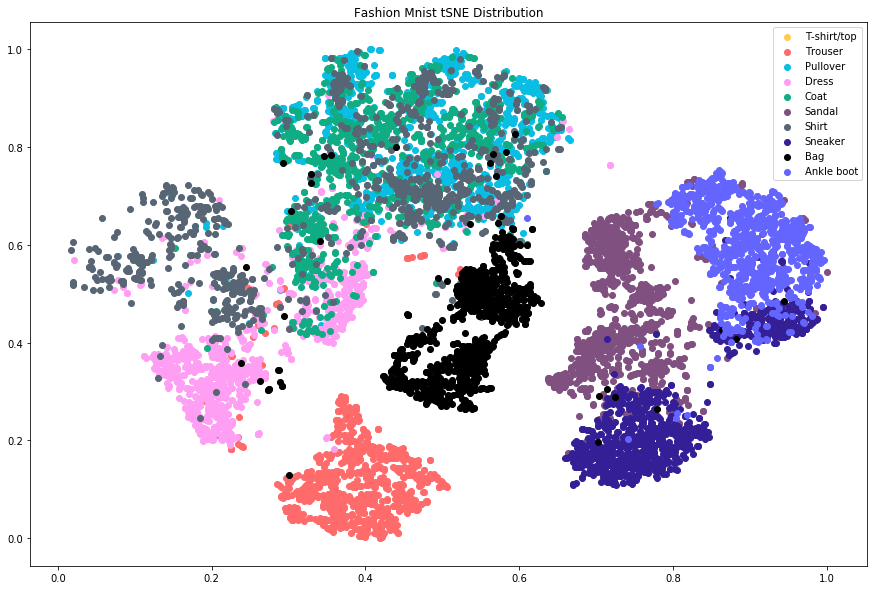

In [28]:
plt.figure(figsize=(15, 10))
count = 0
for label in colors_per_class:
    indices = [i for i, l in enumerate(test_labels) if labels[l] == label]
        
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    
    color = np.array(colors_per_class[label], dtype=np.float) / 255
    
    plt.scatter(current_tx, current_ty, c=color.reshape(1,-1), label=label)

plt.title('Fashion Mnist tSNE Distribution')    
plt.legend(loc='best')
plt.show()

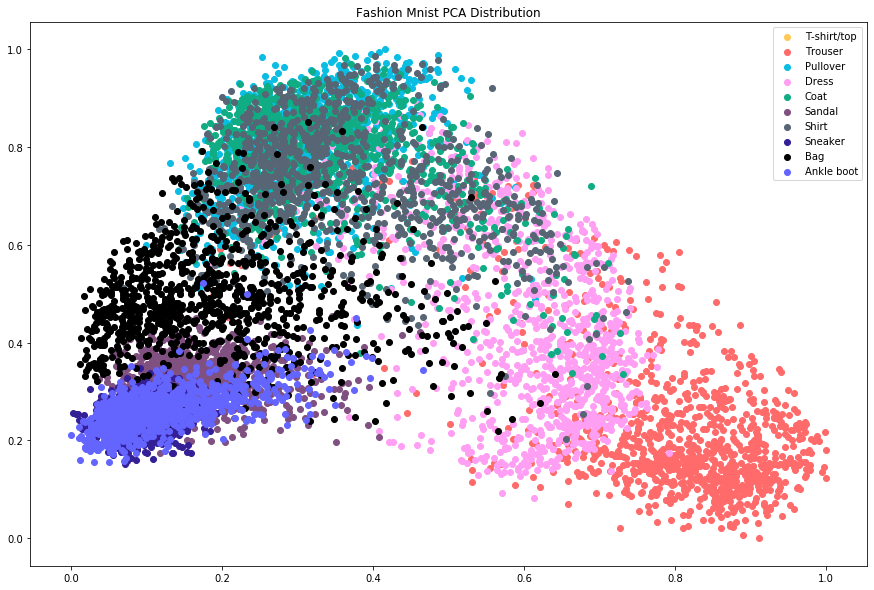

In [27]:
plt.figure(figsize=(15, 10))
count = 0
for label in colors_per_class:
    indices = [i for i, l in enumerate(test_labels) if labels[l] == label]
        
    current_px = np.take(px, indices)
    current_py = np.take(py, indices)
    
    color = np.array(colors_per_class[label], dtype=np.float) / 255
    
    plt.scatter(current_px, current_py, c=color.reshape(1,-1), label=label)
    
plt.title('Fashion Mnist PCA Distribution')
plt.legend(loc='best')
plt.show()

# Save model as torch

In [20]:
if not is_transfer_learning:
    torch.save(model.state_dict(), 'simple_cnn.pth')
else:
    torch.save(model.state_dict(), 'resnet_cnn.pth')

# Convert to ONNX

In [21]:
x = torch.randn(batch_size, 1, 28, 28, requires_grad=True).to(device)
output = model(x)

In [22]:
torch.onnx.export(
    model,
    x, 'fashion_mnist.onnx', export_params=True,
    opset_version=10, do_constant_folding=True,
    input_names=['input'], output_names=['output'],
     dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                'output' : {0 : 'batch_size'}}
)